In [1]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink

import statsmodels.api as sm

from basic_tools import *
import glob

In [2]:
result_file_list=glob.glob(data_out_gcta_path+'*.HEreg')

In [4]:
'data/out_gcta/diabetes.HEreg' in result_file_list

True

In [97]:
import re

In [36]:
with open(result_file,'r') as f:
    a=f.read()
    #print(f.read().strip().strip(r'\s*').split('\n')[1:5])

In [54]:
pd.read_csv(result_file,skiprows=[0,5,6,7,8],sep=r'\s+',index_col=0)

,Estimate,SE_OLS,SE_Jackknife,P_OLS,P_Jackknife
Coefficient,,,,,
Intercept,-0.000012,0.000018,0.000002,0.478663,1.695970e-16
V(G)/Vp,0.000161,0.000117,0.000211,0.169715,4.457210e-01


In [10]:
result_list=[]
for result_file in result_file_list:
    if '-' in result_file:
        continue

    result=pd.read_csv(result_file,skiprows=[0,5,6,7,8],sep=r'\s+',index_col=0)

    #result.index=result['Coefficient']+'_'+['HE-CP','HE-CP','HE-SD','HE-SD']
    #result=result.drop(columns=['Coefficient'])

    result=result.astype(float)
    #break
    result=result.unstack().to_frame().sort_index(level=1).T


    result.columns = result.columns.map(lambda x: '-'.join(x[::-1]))

    result.index=[result_file.split('/')[-1].split('.')[0]]
    result_list.append(result)

In [6]:
result_concat=pd.concat(result_list)

In [59]:
result_concat.sort_index().to_csv(data_out_gcta_path+'result_uni.tsv',sep='\t')

In [54]:
#result_select=result[['Estimate_V(G)/Vp_HE-SD','P_OLS_V(G)/Vp_HE-SD']]
#result_select.columns=['estimate','p']

In [173]:
result_select=result_select[(result_select['estimate']>0)&(result_select['p']<0.01)].sort_values('p')

In [169]:
result_select.to_csv(data_out_gcta_path+'result_uni.tsv',sep='\t')

In [179]:
result.to_csv("result.tsv",sep='\t')

In [62]:
result_concat.columns

Index(['Intercept-Estimate', 'Intercept-P_Jackknife', 'Intercept-P_OLS',
       'Intercept-SE_Jackknife', 'Intercept-SE_OLS', 'V(G)/Vp-Estimate',
       'V(G)/Vp-P_Jackknife', 'V(G)/Vp-P_OLS', 'V(G)/Vp-SE_Jackknife',
       'V(G)/Vp-SE_OLS'],
      dtype='object')

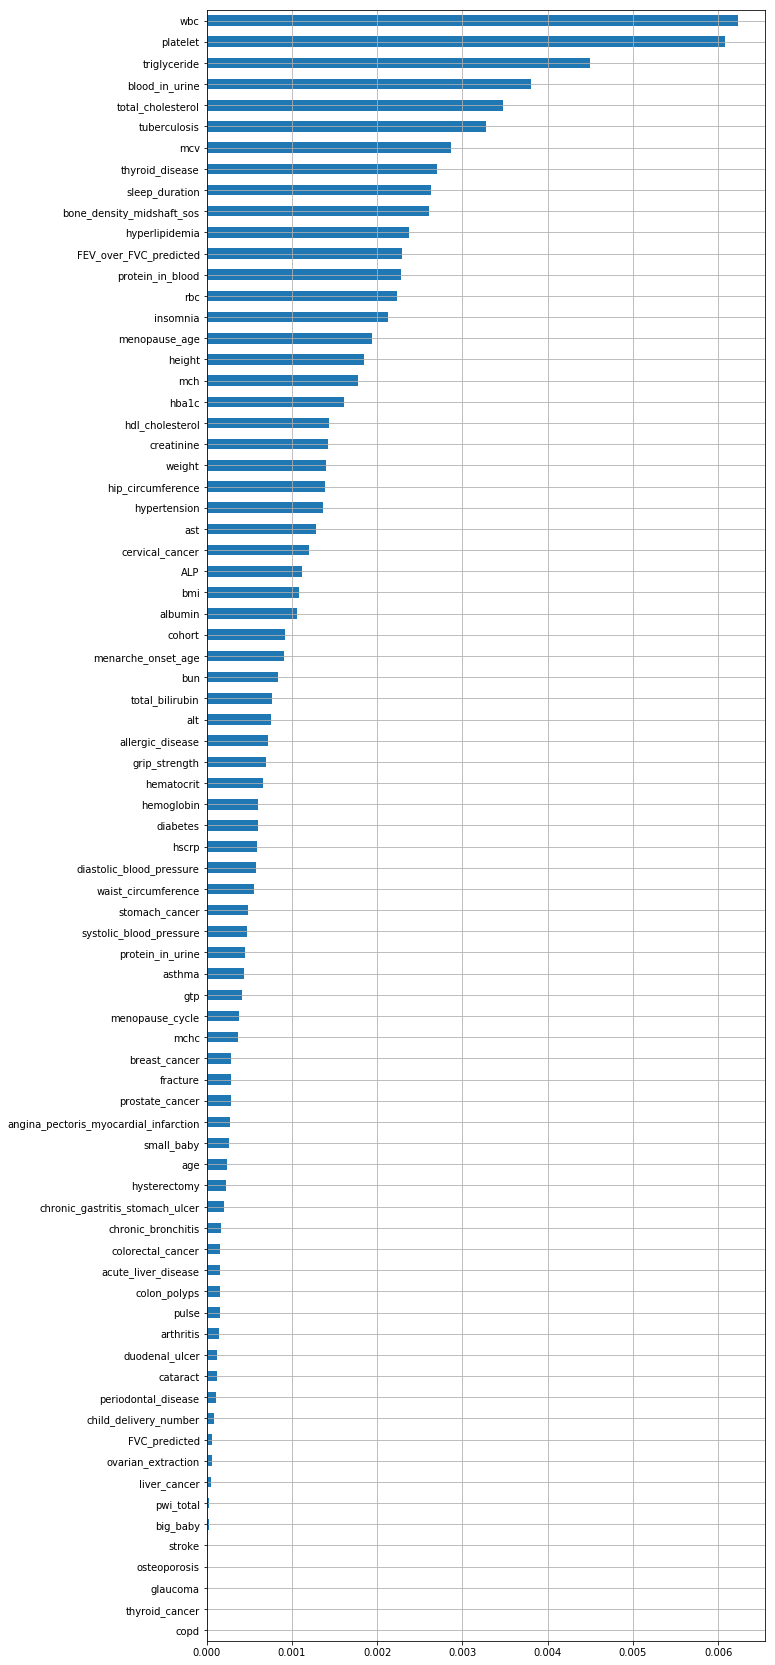

In [15]:
plt.rcParams["figure.figsize"] = (10,30)
plt.rcParams["font.size"] = 10

result_concat[result_concat['V(G)/Vp-Estimate']>0]['V(G)/Vp-Estimate'].sort_values(ascending=True).plot.barh(grid=True)

plt.savefig('temp.png')

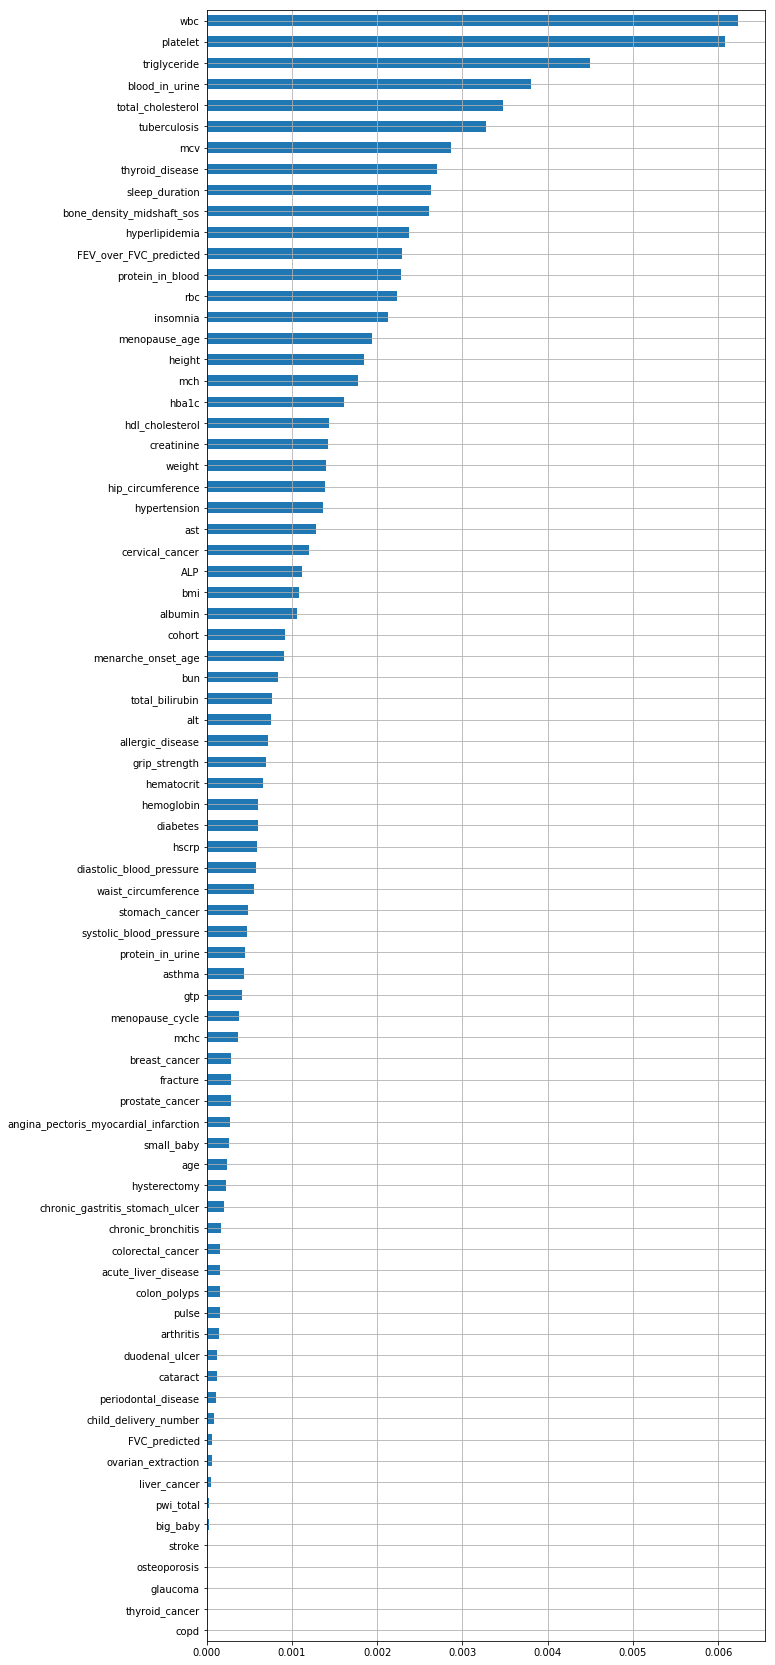

In [88]:
plt.rcParams["figure.figsize"] = (10,30)
plt.rcParams["font.size"] = 10

result_concat[result_concat['V(G)/Vp-Estimate']>0]['V(G)/Vp-Estimate'].sort_values(ascending=True).plot.barh(grid=True)